## Init

In [239]:
import pandas as pd
import numpy as np
import os
import datetime

import pyodbc
from dotenv import load_dotenv

from sklearn.experimental import enable_hist_gradient_boosting, enable_iterative_imputer
from sklearn import datasets, linear_model, ensemble, gaussian_process, isotonic, kernel_ridge, neighbors, neural_network, svm, tree
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, max_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold,train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, FunctionTransformer,  StandardScaler, LabelEncoder, LabelBinarizer, OrdinalEncoder, RobustScaler
from sklearn.inspection import permutation_importance
import joblib

import lightgbm  
import xgboost 
import catboost
# from keras.wrappers.scikit_learn import KerasRegressor
# from keras.models import Sequential
# from keras.layers import Dense
import optuna

# visualization lib
import matplotlib.pyplot as plt
import seaborn as sns
from rfpimp import permutation_importances, plot_importances, plot_corr_heatmap
# import shap
import eli5
from eli5.sklearn import PermutationImportance
from pandas_profiling import ProfileReport

from helper import absolute_score, show_pred, show_feature_importances, reduce_mem_usage

In [240]:
load_dotenv()

True

In [241]:
DATASET_MARKET = 'off-trade'
DATASET_COUNTRY = 'all'

DATASET_NAME = f'{DATASET_MARKET}_{DATASET_COUNTRY}'

if (DATASET_MARKET == 'on-trade'):
    DATASET_FROM_YEAR = 2021
    DATASET_FROM_WEEK = 25
    DATASET_TO_YEAR = 2021
    DATASET_TO_WEEK = 30

if (DATASET_MARKET == 'off-trade'):
    DATASET_FROM_YEAR = 2021
    DATASET_FROM_WEEK = 25
    DATASET_TO_YEAR = 2021
    DATASET_TO_WEEK = 30

DATA_PATH = f'./data/{DATASET_NAME}_pred_data.csv'

MODEL_PATH = f'./models/{DATASET_NAME}_model.joblib'
SCALER_PATH = f'./models/{DATASET_NAME}_scaler.joblib'
IMPUTER_PATH = f'./models/{DATASET_NAME}_imputer.joblib'
SKU_ENCODER_PATH = f'./models/{DATASET_NAME}_sku_encoder.joblib'
BRAND_ENCODER_PATH = f'./models/{DATASET_NAME}_brand_encoder.joblib'

RESULT_CSV_PATH = f'./pred_results/{DATASET_NAME}_pred_result.csv'
RESULT_EXCEL_PATH = f'./pred_results/{DATASET_NAME}_pred_result.xlsx'

MAX_N_JOBS = 8

## Load Model

In [242]:
model = joblib.load(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)
imputer = joblib.load(IMPUTER_PATH)
sku_encoder = joblib.load(SKU_ENCODER_PATH)
brand_encoder = joblib.load(BRAND_ENCODER_PATH)

## Load data

In [243]:
try:
    server = os.getenv('DB_SERVER')
    database = os.getenv('DB_DATABASE')
    username = os.getenv('DB_USERNAME')
    password = os.getenv('DB_PASSWORD')

    cnxn = pyodbc.connect(f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}') 

    country_par = 'NULL' if DATASET_COUNTRY == 'all' else DATASET_COUNTRY
    query1=f'EXEC [dbo].[ML_Table_extension_data] @Country={country_par}, @FromYear={DATASET_FROM_YEAR}, @FromWeek={DATASET_FROM_WEEK}, @ToYear={DATASET_TO_YEAR}, @ToWeek={DATASET_TO_WEEK}, @Market="{DATASET_MARKET.upper()}", @FillMissingWeeks=1'
    
    data = pd.read_sql(query1, cnxn)

    data.to_csv(DATA_PATH, index=False)
except:
    print("Unexpected error:", sys.exc_info()[0])
    data = pd.read_csv(DATA_PATH, header=0)
else:
    cnxn.close()

data = data.sort_values(by=['Year', 'Week', 'SkuShort', 'Country']).reset_index().drop(columns=['index'])    
data.head()

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,PrevNumberWorkdays,NextNumberWorkdays,AvgTemp,AvgRain,...,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,SalesHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,OldPredSalesHl
0,01015,PILSNER URQUELL,CZ,2021,25,5,5,5,19.767857,5.267857,...,False,6282.464286,6767.831502,7688.165399,1020.9000,4250.8000,10797.2000,10124.3000,5924.3000,None
1,01015,PILSNER URQUELL,SK,2021,25,5,5,5,19.767857,5.267857,...,False,486.502068,1370.951472,1618.455554,202.7000,1430.8000,2338.7000,1952.6000,1641.5000,None
2,01016,PILSNER URQUELL,CZ,2021,25,5,5,5,19.767857,5.267857,...,False,464.142857,357.000000,525.611120,70.2504,323.8488,393.0696,248.1336,384.5952,None
3,01016,PILSNER URQUELL,SK,2021,25,5,5,5,19.767857,5.267857,...,False,39.204667,14.204667,46.467466,13.1472,67.8744,64.6272,63.0432,64.5480,None
4,01022,PILSNER URQUELL,CZ,2021,25,5,5,5,19.767857,5.267857,...,False,NaN,NaN,0.025409,NaN,NaN,NaN,NaN,37.0150,None


In [244]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1446 entries, 0 to 1445
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SkuShort            1446 non-null   object 
 1   Brand               1446 non-null   object 
 2   Country             1446 non-null   object 
 3   Year                1446 non-null   int64  
 4   Week                1446 non-null   int64  
 5   NumberWorkdays      1446 non-null   int64  
 6   PrevNumberWorkdays  1446 non-null   int64  
 7   NextNumberWorkdays  1446 non-null   int64  
 8   AvgTemp             1446 non-null   float64
 9   AvgRain             1446 non-null   float64
 10  AvgSun              1446 non-null   float64
 11  IsLockdown          1446 non-null   bool   
 12  PdtHl               903 non-null    float64
 13  PrevWeekPdtHl1      894 non-null    float64
 14  BgtHl               1106 non-null   float64
 15  SalesHl             183 non-null    float64
 16  PrevWe

In [245]:
data = reduce_mem_usage(data, ignoreCols=['SalesHl'])

Mem. usage decreased to  0.09 Mb (58.4% reduction)


## Preprocessing

In [246]:
cols_drop = ['SalesHl', 'OldPredSalesHl']
X = data.drop(cols_drop, axis=1)
X_raw = X.copy(deep=True)
y = data.SalesHl.fillna(0).to_numpy()

In [247]:
Country_mapping = {"CZ": 1, "SK": 2}

X.Country = X.Country.map(Country_mapping)

X.SkuShort = X.SkuShort.map(lambda s: 'other' if s not in sku_encoder.classes_ else s)
sku_encoder.classes_ = np.append(sku_encoder.classes_ , 'other')
X.SkuShort = sku_encoder.transform(X.SkuShort)

X.Brand = X.Brand.map(lambda s: 'other' if s not in brand_encoder.classes_ else s)
brand_encoder.classes_ = np.append(brand_encoder.classes_ , 'other')
X.Brand = brand_encoder.transform(X.Brand)

X.head()

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,PrevNumberWorkdays,NextNumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2
0,0,12,1,2021,25,5,5,5,19.765625,5.269531,5.265625,False,6284.00000,6768.000000,7688.000000,4252.000,10800.000,10128.00000,5924.0000
1,0,12,2,2021,25,5,5,5,19.765625,5.269531,5.265625,False,486.50000,1371.000000,1618.000000,1431.000,2338.000,1953.00000,1642.0000
2,1,12,1,2021,25,5,5,5,19.765625,5.269531,5.265625,False,464.25000,357.000000,525.500000,323.750,393.000,248.12500,384.5000
3,1,12,2,2021,25,5,5,5,19.765625,5.269531,5.265625,False,39.21875,14.203125,46.468750,67.875,64.625,63.03125,64.5625
4,2,12,1,2021,25,5,5,5,19.765625,5.269531,5.265625,False,NaN,NaN,0.025406,NaN,NaN,NaN,37.0000


In [248]:
X.BgtHl = X.BgtHl.fillna(0)
X.PdtHl = X.PdtHl.fillna(0)
X.PrevWeekPdtHl1 = X.PrevWeekPdtHl1.fillna(0)
X.PrevNumberWorkdays = X.PrevNumberWorkdays.fillna(5)
X.NextNumberWorkdays = X.NextNumberWorkdays.fillna(5)

In [249]:
X = pd.DataFrame(imputer.transform(X), columns=X.columns)
X

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,PrevNumberWorkdays,NextNumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2
0,0.0,12.0,1.0,2021.0,25.0,5.0,5.0,5.0,19.765625,5.269531,5.265625,0.0,6284.00000,6768.000000,7688.000000,4252.000000,10800.00000,10128.000000,5924.000000
1,0.0,12.0,2.0,2021.0,25.0,5.0,5.0,5.0,19.765625,5.269531,5.265625,0.0,486.50000,1371.000000,1618.000000,1431.000000,2338.00000,1953.000000,1642.000000
2,1.0,12.0,1.0,2021.0,25.0,5.0,5.0,5.0,19.765625,5.269531,5.265625,0.0,464.25000,357.000000,525.500000,323.750000,393.00000,248.125000,384.500000
3,1.0,12.0,2.0,2021.0,25.0,5.0,5.0,5.0,19.765625,5.269531,5.265625,0.0,39.21875,14.203125,46.468750,67.875000,64.62500,63.031250,64.562500
4,2.0,12.0,1.0,2021.0,25.0,5.0,5.0,5.0,19.765625,5.269531,5.265625,0.0,0.00000,0.000000,0.025406,636.006664,639.91655,656.044551,37.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1441,261.0,11.0,1.0,2021.0,30.0,5.0,5.0,5.0,22.000000,1.125000,8.695312,0.0,0.00000,0.000000,0.000000,636.006664,639.91655,656.044551,688.739572
1442,262.0,11.0,1.0,2021.0,30.0,5.0,5.0,5.0,22.000000,1.125000,8.695312,0.0,1523.00000,0.000000,0.000000,636.006664,639.91655,656.044551,688.739572
1443,263.0,11.0,1.0,2021.0,30.0,5.0,5.0,5.0,22.000000,1.125000,8.695312,0.0,0.00000,0.000000,0.000000,636.006664,639.91655,656.044551,688.739572
1444,265.0,11.0,1.0,2021.0,30.0,5.0,5.0,5.0,22.000000,1.125000,8.695312,0.0,692.00000,0.000000,0.000000,636.006664,639.91655,656.044551,688.739572


### Pred PrevWeekSalesHl1 and PrevWeekSalesHl2

In [250]:
year_week = X[['Year','Week']].drop_duplicates()

for year_week_index, year_week_row in year_week.iterrows():
    print(year_week_row.Year, year_week_row.Week)

    X_week = X[(X.Year == year_week_row.Year) & (X.Week == year_week_row.Week)].copy(deep=True)

    # X_week['AvgPrevWeekSalesHl'] = X_week[['PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(1)
    X_week['AvgPrevYearSalesHl'] = X_week[['PrevYearSalesHl1', 'PrevYearSalesHl2']].mean(axis=1).round(1)
    X_week['AvgPrevAllSalesHl'] = X_week[['PrevYearSalesHl1', 'PrevYearSalesHl2', 'PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(1)

    X_week = X_week.drop(['PrevWeekSalesHl1', 'PrevWeekSalesHl2'], axis=1)

    X_week = pd.DataFrame(scaler.transform(X_week), columns=X_week.columns)

    y_pred = model.predict(X_week)
    y_pred[y_pred < 0] = 0
    y_pred = y_pred.round(0)

    X_week['PredSalesHl'] = y_pred

    for X_week_index, X_week_row in X_week.iterrows():
        X.at[(X.Year == X_week_row.Year) & (X.Week == X_week_row.Week+1) & (X.SkuShort == X_week_row.SkuShort) & (X.Country == X_week_row.Country), 'PrevWeekSalesHl1'] = X_week_row.PredSalesHl
        X.at[(X.Year == X_week_row.Year) & (X.Week == X_week_row.Week+2) & (X.SkuShort == X_week_row.SkuShort) & (X.Country == X_week_row.Country), 'PrevWeekSalesHl2'] = X_week_row.PredSalesHl


2021.0 25.0
2021.0 26.0
2021.0 27.0
2021.0 28.0
2021.0 29.0
2021.0 30.0


In [251]:
# X['AvgPrevWeekSalesHl'] = X[['PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(1)
X['AvgPrevYearSalesHl'] = X[['PrevYearSalesHl1', 'PrevYearSalesHl2']].mean(axis=1).round(1)
X['AvgPrevAllSalesHl'] = X[['PrevYearSalesHl1', 'PrevYearSalesHl2', 'PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(1)

X = X.drop(['PrevWeekSalesHl1', 'PrevWeekSalesHl2'], axis=1)

In [252]:
X = pd.DataFrame(scaler.transform(X), columns=X.columns)

## Predict

In [253]:
y_pred = model.predict(X)
y_pred[y_pred < 0] = 0
y_pred = y_pred.round(0)

In [254]:
print(DATASET_NAME)
print('----------------')
print('Coefficient of determination: %.4f'% r2_score(y, y_pred))
print('Absolute Score: %.4f'% absolute_score(y, y_pred))
print('Mean absolute error regression loss.: %.4f'% mean_absolute_error(y, y_pred))
print('Maximum residual error: %.4f'% max_error(y, y_pred))
print('Mean squared error regression loss: %.4f'% mean_squared_error(y, y_pred))

off-trade_all
----------------
Coefficient of determination: -113.8997
Absolute Score: -25.7138
Mean absolute error regression loss.: 537.9511
Maximum residual error: 12707.0000
Mean squared error regression loss: 1757964.1032


In [255]:
# off-trade_all
# ----------------
# Coefficient of determination: 0.8611
# Absolute Score: 0.6373
# Mean absolute error regression loss.: 217.3679
# Maximum residual error: 6175.9000
# Mean squared error regression loss: 326206.0454

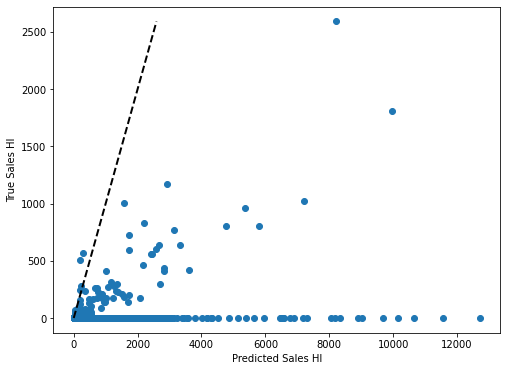

In [256]:
show_pred(y, y_pred, "Predicted Sales Hl", "True Sales Hl")

## Save Result 

In [257]:
result = X_raw.copy(deep=True)
result["PredSalesHl_ML"] = y_pred

result = result.drop(['PrevNumberWorkdays', 'NextNumberWorkdays'], axis=1)

dir_path = os.path.dirname(RESULT_CSV_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)
 
result.to_csv(RESULT_CSV_PATH, index=False)
result.to_excel(RESULT_EXCEL_PATH, index=False)